# Inference with SwinUNETR (Adapted to Semantic Segmentation)

This notebook demonstrates the inference process using the Swin UNETR model, a Swin-based transformer for 3D medical image analysis. The model is pre-trained in a self-supervised manner with proxy tasks tailored to learn underlying patterns of human anatomy, making it effective for segmentation tasks in volumetric medical images.

The goal of this notebook is to:
- Load a pre-trained SwinUNETR model.
- Perform segmentation of covid affected areas
- Visualize the segmentation results.

#### DISCLAIMER
The code presented in this experiment was developed by the authors of this research

For more details, see the original article: [Self-Supervised Pre-Training of Swin Transformers for 3D Medical Image Analysis](https://www.semanticscholar.org/paper/Self-Supervised-Pre-Training-of-Swin-Transformers-Tang-Yang/076a8e778f2e9efb3c2fd45fed534ae9e6035f1b).

>@article{Tang2021SelfSupervisedPO,  
  title={Self-Supervised Pre-Training of Swin Transformers for 3D Medical Image Analysis},  
  author={Yucheng Tang and Dong Yang and Wenqi Li and Holger R. Roth and Bennett A. Landman and Daguang Xu and V. Nath and Ali Hatamizadeh},  
  journal={2022 IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},  
  year={2021},  
  pages={20698-20708},  
  url={https://api.semanticscholar.org/CorpusID:244715046}  
}

## Architecture

SwinUNETR is composed of:
- **Swin Transformer Encoder:** Uses 3D input patches and a hierarchical architecture with *shifted windowing* mechanisms to efficiently compute self-attention. This allows modeling both global and local information at different resolutions, which is crucial for volumetric images.
- **CNN-Based Decoder:** Connected to the encoder via *skip connections* at different resolutions, similar to the UNet architecture, enabling dense inference and recovery of fine spatial details.
- **Segmentation Head:** Attached at the end of the decoder to compute the final segmentation output.

## Setting Environment



In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 38.5 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import tempfile
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
import torch
import einops
import warnings


warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading data

In [ ]:
!mkdir -p ../data/images
!mkdir -p ../data/masks

!wget -O ../data/COVID-19-CT-Seg_20cases.zip 'https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1'
!wget -O ../data/Lung_and_Infection_Mask.zip 'https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1'

!unzip -qq ../data/COVID-19-CT-Seg_20cases.zip -d ../data/images
!unzip -qq ../data/Lung_and_Infection_Mask.zip -d ../data/masks

--2025-09-29 14:00:26--  https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3757476/files/COVID-19-CT-Seg_20cases.zip [following]
--2025-09-29 14:00:27--  https://zenodo.org/records/3757476/files/COVID-19-CT-Seg_20cases.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1105395143 (1.0G) [application/octet-stream]
Saving to: ‘../data/COVID-19-CT-Seg_20cases.zip’

../data/COVID-19-CT  67%[============>       ] 713.37M  --.-KB/s    in 4m 29s  

2025-09-29 14:04:57 (2.65 MB/s) - Connection closed at byte 748025532. Retrying.

--2025-09-29 14:04:58--  (try: 2)  https://zenodo.org/records/3757476/files/COVID-19-CT-Seg_20cases.zip
Connecting to zenodo.org (zenodo.org)|188.185

## Moving data to google drive, for persistence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define the source and destination paths
source_dir = '../data'
destination_dir = '/content/drive/MyDrive/SIBGRAPI/SwinUNETR/'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Move the files
for item_name in os.listdir(source_dir):
    source_item = os.path.join(source_dir, item_name)
    destination_item = os.path.join(destination_dir, item_name)
    shutil.move(source_item, destination_item)

print(f"Moved contents of {source_dir} to {destination_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Moved contents of ../data to /content/drive/MyDrive/SIBGRAPI/SwinUNETR/


### Checking data

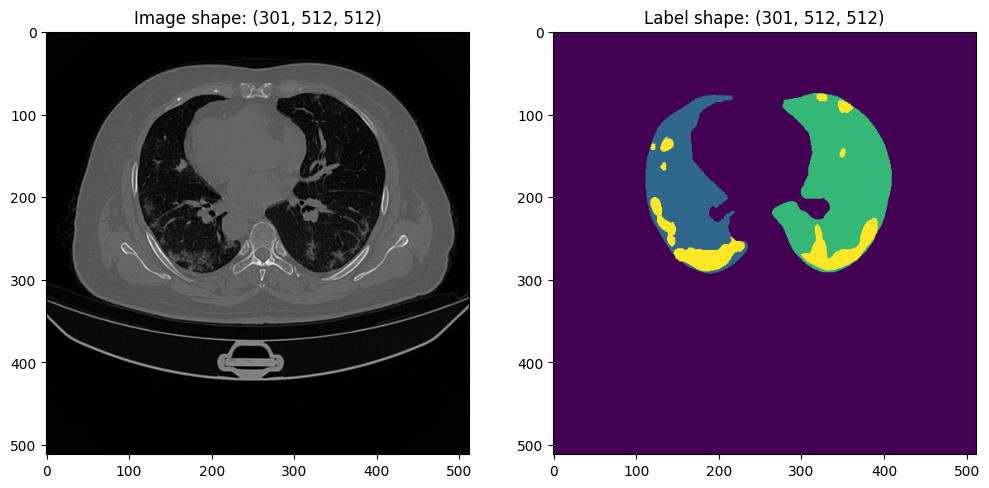

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

root_path = "/content/drive/MyDrive/SIBGRAPI/SwinUNETR/"
img_path = root_path + 'images/coronacases_001.nii.gz'
mask_path = root_path + 'masks/coronacases_001.nii.gz'

test_image_nib = nib.load(img_path)
test_mask_nib = nib.load(mask_path)
test_image = np.transpose(test_image_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]
test_mask = np.transpose(test_mask_nib.get_fdata(), (2, 1, 0))[:, -1::-1, -1::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

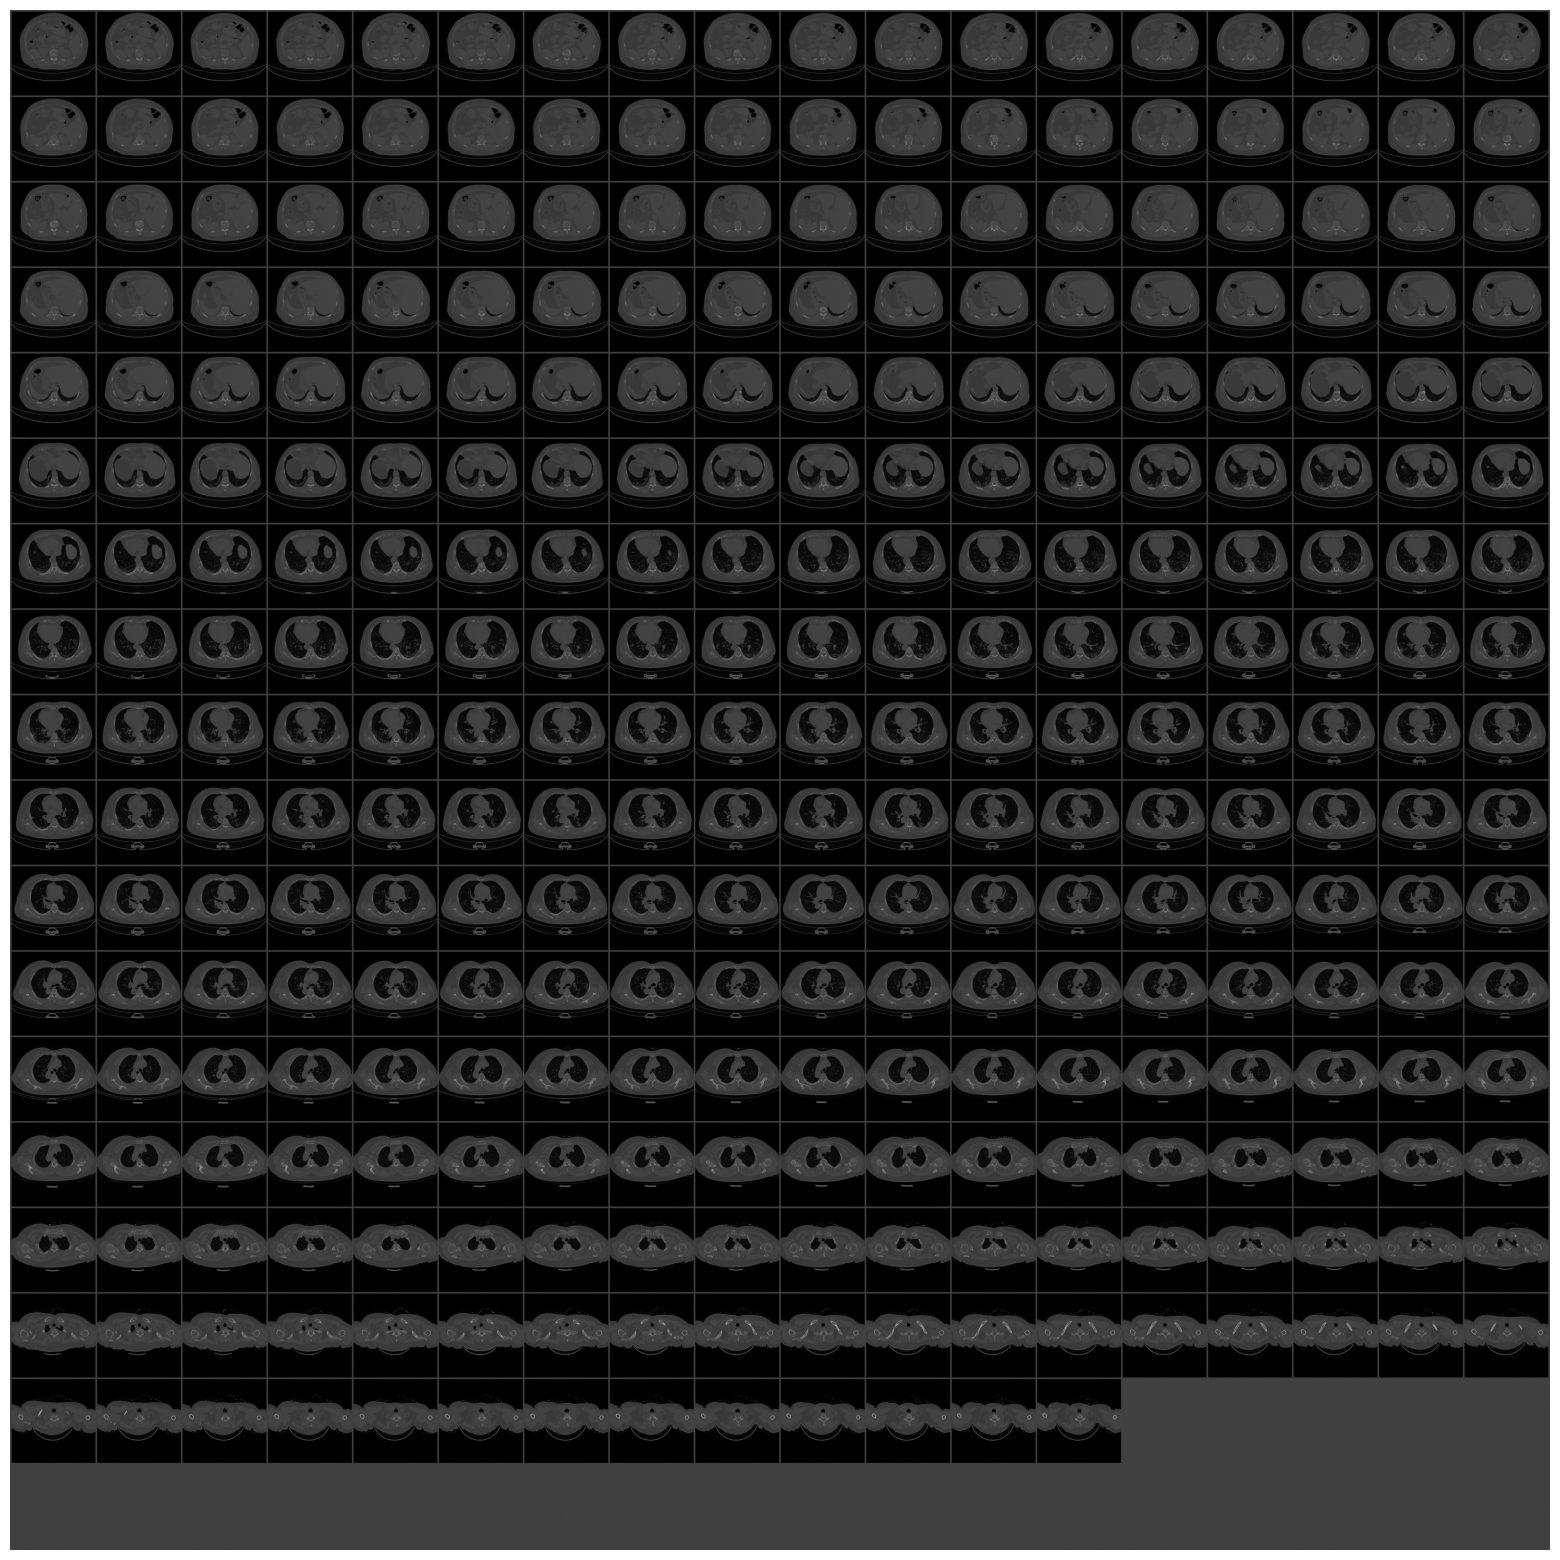

In [ ]:
from skimage.util import montage

fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(test_image, padding_width=10, fill=1), cmap='gray')
plt.axis('off')
plt.show()

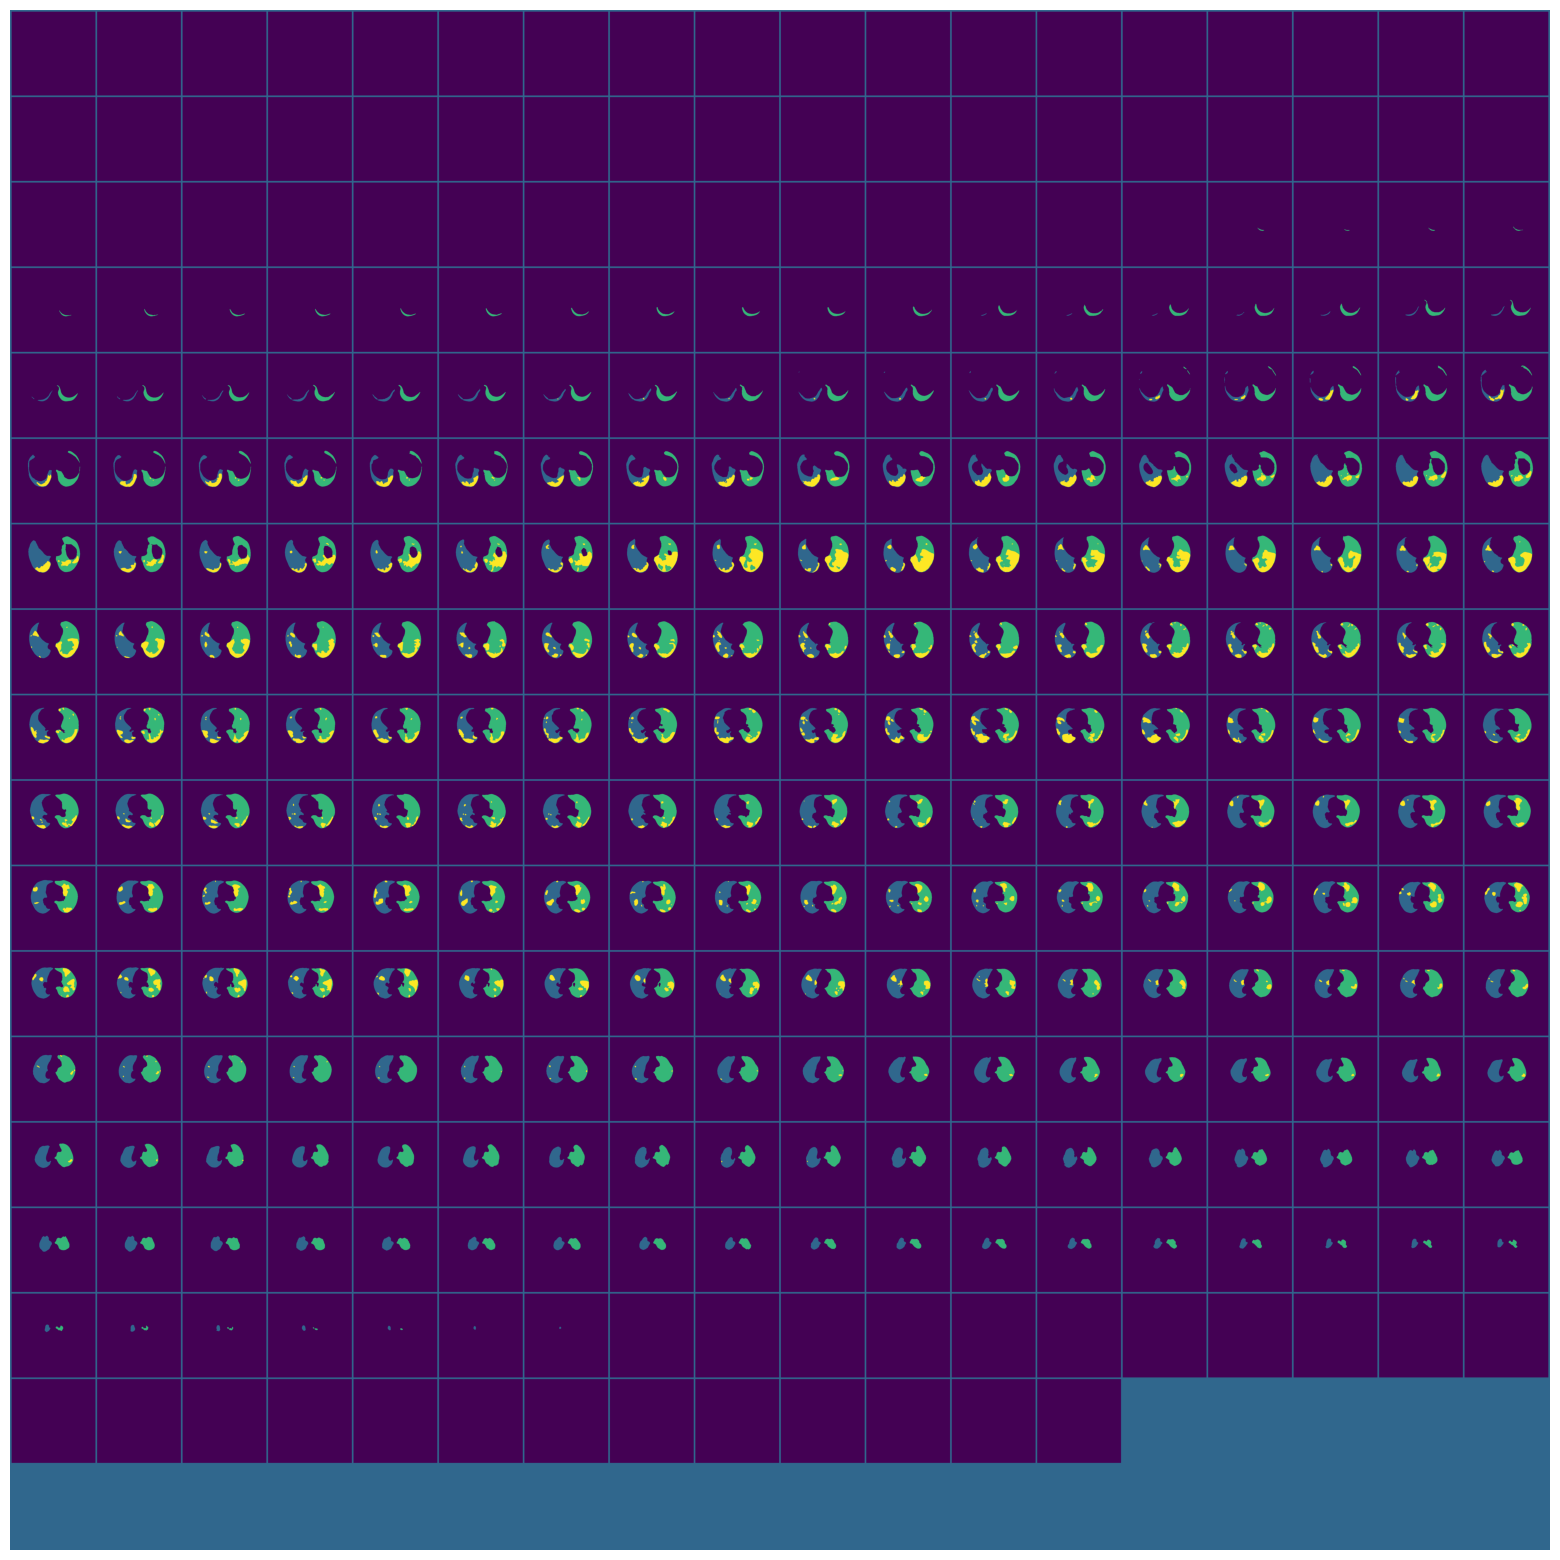

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(test_mask, padding_width=10, fill=1))
plt.axis('off')
plt.show()

### Transforms

In [ ]:
num_samples = 1
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        EnsureTyped(keys=["image"], device=device, track_meta=True),
    ]
)

### Creating Dataset


In [ ]:
import glob
import json
import pprint


dataset_json = {
    "labels": {
        "0": "background",
        "1": "left lung",
        "2": "left lung",
        "3": "infections"
    },
    "tensorImageSize": "3D",
    "training": [],
    "validation": []
}
root_path = "/content/drive/MyDrive/SIBGRAPI/SwinUNETR/"
masks_paths = sorted(glob.glob(root_path + 'masks/*.nii.gz'))
for path in masks_paths[:-2]:
    filename = path.rsplit('/', 1)[-1]
    dataset_json["training"].append({
        "image": f'images/{filename}',
        "label": f'masks/{filename}',
    })
for path in masks_paths[-2:]:
    filename = path.rsplit('/', 1)[-1]
    dataset_json["validation"].append({
        "image": f'images/{filename}',
        "label": f'masks/{filename}',
    })

datasets = root_path + 'dataset.json'
with open(datasets, 'w') as outfile:
    json.dump(dataset_json, outfile)

pprint.pprint(dataset_json)

{'labels': {'0': 'background',
            '1': 'left lung',
            '2': 'left lung',
            '3': 'infections'},
 'tensorImageSize': '3D',
 'training': [{'image': 'images/coronacases_001.nii.gz',
               'label': 'masks/coronacases_001.nii.gz'},
              {'image': 'images/coronacases_002.nii.gz',
               'label': 'masks/coronacases_002.nii.gz'},
              {'image': 'images/coronacases_003.nii.gz',
               'label': 'masks/coronacases_003.nii.gz'},
              {'image': 'images/coronacases_004.nii.gz',
               'label': 'masks/coronacases_004.nii.gz'},
              {'image': 'images/coronacases_005.nii.gz',
               'label': 'masks/coronacases_005.nii.gz'},
              {'image': 'images/coronacases_006.nii.gz',
               'label': 'masks/coronacases_006.nii.gz'},
              {'image': 'images/coronacases_007.nii.gz',
               'label': 'masks/coronacases_007.nii.gz'},
              {'image': 'images/coronacases_008.nii.g

In [ ]:
train_files = load_decathlon_datalist(datasets, True, "training")
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_num=24, cache_rate=1.0, num_workers=2
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=2
)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

set_track_meta(False)

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.75s/it]


### Check

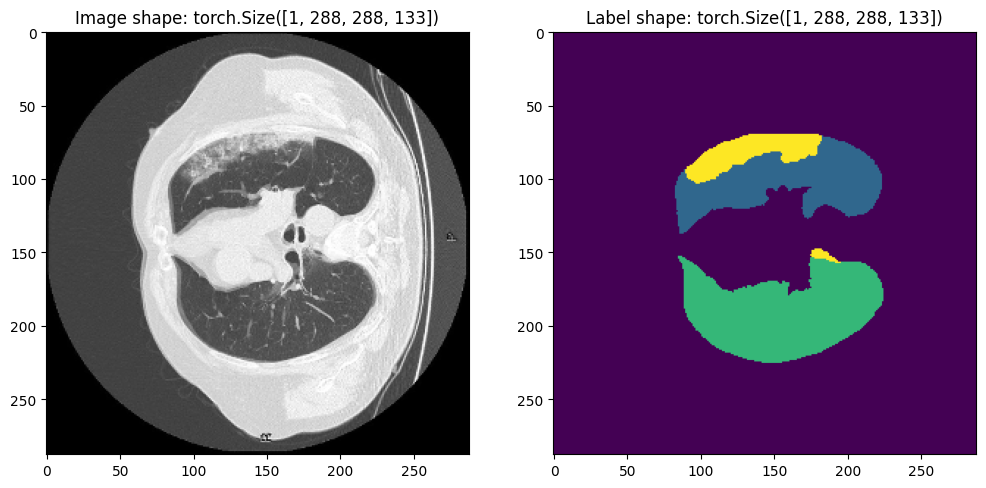

In [ ]:
case_num = 1
slice_num = 50

img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img[0, :, :, slice_num].detach().cpu(), cmap="gray")
ax1.set_title(f'Image shape: {img.shape}')
ax2.imshow(label[0, :, :, slice_num].detach().cpu())
ax2.set_title(f'Label shape: {label.shape}')
plt.show()

## Model

### Creating Model

In [ ]:
model = SwinUNETR(
    in_channels=1,
    out_channels=4,
    feature_size=48,
    use_checkpoint=True,
).to(device)

### Loading SSL pretrained weights

In [ ]:
!wget -O model_swinvit.pt https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

--2025-09-29 19:22:12--  https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/366729051/c7bc9f02-a8fb-4527-b311-e308fce79182?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-29T20%3A05%3A36Z&rscd=attachment%3B+filename%3Dmodel_swinvit.pt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-29T19%3A04%3A51Z&ske=2025-09-29T20%3A05%3A36Z&sks=b&skv=2018-11-09&sig=Pr1w6b32H97jsyzwgQEbPyW8eiN2kNO1%2BepB8LO9vfA%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1OTE3NDAzMywibmJmIjoxNzU5MTczNzMzLCJwYXRoIjoicmVsZWFzZWFzc2V

In [ ]:
weight = torch.load("model_swinvit.pt")
model.load_from(weights=weight)

### Training

In [ ]:
checkpoints_path = "/content/drive/MyDrive/SIBGRAPI/SwinUNETR/checkpoints/"
os.makedirs(checkpoints_path, exist_ok=True)

In [ ]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 1.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), checkpoints_path_no_ssl + "best_metric_model.pth")
                print(f"\nModel Was Saved ! Current Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")
            else:
                print(f"\nModel Was Not Saved ! Current Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
import gc
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

max_iterations = 15000
eval_num = 500
post_label = AsDiscrete(to_onehot=4) # class n
post_pred = AsDiscrete(argmax=True, to_onehot=4) # class n
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    gc.collect()
    torch.cuda.empty_cache()
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(checkpoints_path + "best_metric_model.pth"))

Training (500 / 15000 Steps) (loss=0.97942):  83%|████████▎ | 15/18 [00:38<00:28,  9.56s/it]


Model Was Saved ! Current Best Avg. Dice: 0.49782148003578186 Current Avg. Dice: 0.49782148003578186


Training (1000 / 15000 Steps) (loss=0.92355):  61%|██████    | 11/18 [00:18<00:29,  4.25s/it]


Model Was Saved ! Current Best Avg. Dice: 0.5677500367164612 Current Avg. Dice: 0.5677500367164612


Training (1500 / 15000 Steps) (loss=0.83734):  39%|███▉      | 7/18 [00:15<00:47,  4.33s/it]


Model Was Saved ! Current Best Avg. Dice: 0.650886058807373 Current Avg. Dice: 0.650886058807373


Training (2000 / 15000 Steps) (loss=0.84518):  17%|█▋        | 3/18 [00:12<01:23,  5.54s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.650886058807373 Current Avg. Dice: 0.590569019317627


Training (2500 / 15000 Steps) (loss=0.92754):  94%|█████████▍| 17/18 [00:21<00:03,  3.84s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.650886058807373 Current Avg. Dice: 0.6335858702659607


Training (3000 / 15000 Steps) (loss=0.71534):  72%|███████▏  | 13/18 [00:18<00:19,  3.89s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.650886058807373 Current Avg. Dice: 0.578580379486084


Training (3500 / 15000 Steps) (loss=0.63505):  50%|█████     | 9/18 [00:21<00:49,  5.54s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7090097665786743 Current Avg. Dice: 0.7090097665786743


Training (4000 / 15000 Steps) (loss=0.58468):  28%|██▊       | 5/18 [00:14<01:02,  4.83s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7300794124603271 Current Avg. Dice: 0.7300794124603271


Training (4500 / 15000 Steps) (loss=0.80424):   6%|▌         | 1/18 [00:11<03:13, 11.38s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7300794124603271 Current Avg. Dice: 0.6740291118621826


Training (5000 / 15000 Steps) (loss=0.53255):  83%|████████▎ | 15/18 [00:21<00:12,  4.16s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7820740938186646 Current Avg. Dice: 0.7820740938186646


Training (5500 / 15000 Steps) (loss=0.54774):  61%|██████    | 11/18 [00:17<00:27,  3.90s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7820740938186646 Current Avg. Dice: 0.7479759454727173


Training (6000 / 15000 Steps) (loss=0.59432):  39%|███▉      | 7/18 [00:15<00:48,  4.40s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7906390428543091 Current Avg. Dice: 0.7906390428543091


Training (6500 / 15000 Steps) (loss=0.62144):  17%|█▋        | 3/18 [00:13<01:28,  5.93s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8013750910758972 Current Avg. Dice: 0.8013750910758972


Training (7000 / 15000 Steps) (loss=0.57853):  94%|█████████▍| 17/18 [00:21<00:03,  3.85s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8013750910758972 Current Avg. Dice: 0.7927254438400269


Training (7500 / 15000 Steps) (loss=0.43028):  72%|███████▏  | 13/18 [00:19<00:20,  4.14s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8177139759063721 Current Avg. Dice: 0.8177139759063721


Training (8000 / 15000 Steps) (loss=0.70185):  50%|█████     | 9/18 [00:16<00:35,  3.97s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8177139759063721 Current Avg. Dice: 0.6898037195205688


Training (8500 / 15000 Steps) (loss=0.57859):  28%|██▊       | 5/18 [00:14<00:58,  4.53s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8177139759063721 Current Avg. Dice: 0.767428994178772


Training (9000 / 15000 Steps) (loss=0.60713):   6%|▌         | 1/18 [00:12<03:29, 12.30s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8764513731002808 Current Avg. Dice: 0.8764513731002808


Training (9500 / 15000 Steps) (loss=0.54752):  83%|████████▎ | 15/18 [00:21<00:12,  4.14s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8880195617675781


Training (10000 / 15000 Steps) (loss=0.43365):  61%|██████    | 11/18 [00:17<00:27,  3.91s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8489271998405457


Training (10500 / 15000 Steps) (loss=0.38758):  39%|███▉      | 7/18 [00:15<00:45,  4.15s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8782263994216919


Training (11000 / 15000 Steps) (loss=0.52279):  17%|█▋        | 3/18 [00:12<01:23,  5.54s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8322888016700745


Training (11500 / 15000 Steps) (loss=0.55529):  94%|█████████▍| 17/18 [00:21<00:03,  3.85s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8518761992454529


Training (12000 / 15000 Steps) (loss=0.56330):  72%|███████▏  | 13/18 [00:18<00:19,  3.88s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8694964647293091


Training (12500 / 15000 Steps) (loss=0.51700):  50%|█████     | 9/18 [00:16<00:35,  3.99s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.8752427101135254


Training (13000 / 15000 Steps) (loss=0.61244):  28%|██▊       | 5/18 [00:14<00:58,  4.54s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8880195617675781 Current Avg. Dice: 0.7779966592788696


Training (13500 / 15000 Steps) (loss=0.32113):   6%|▌         | 1/18 [00:12<03:27, 12.19s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8970010280609131 Current Avg. Dice: 0.8970010280609131


Training (14000 / 15000 Steps) (loss=0.56224):  83%|████████▎ | 15/18 [00:20<00:11,  3.86s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8970010280609131 Current Avg. Dice: 0.866545557975769


Training (14500 / 15000 Steps) (loss=0.56342):  61%|██████    | 11/18 [00:17<00:27,  3.90s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8970010280609131 Current Avg. Dice: 0.8407254815101624


Training (15000 / 15000 Steps) (loss=0.75192):  39%|███▉      | 7/18 [00:15<00:45,  4.13s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8970010280609131 Current Avg. Dice: 0.8789113759994507


Training (15011 / 15000 Steps) (loss=0.26116): 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


<All keys matched successfully>

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} at iteration: {global_step_best}")

train completed, best_metric: 0.8970 at iteration: 13500


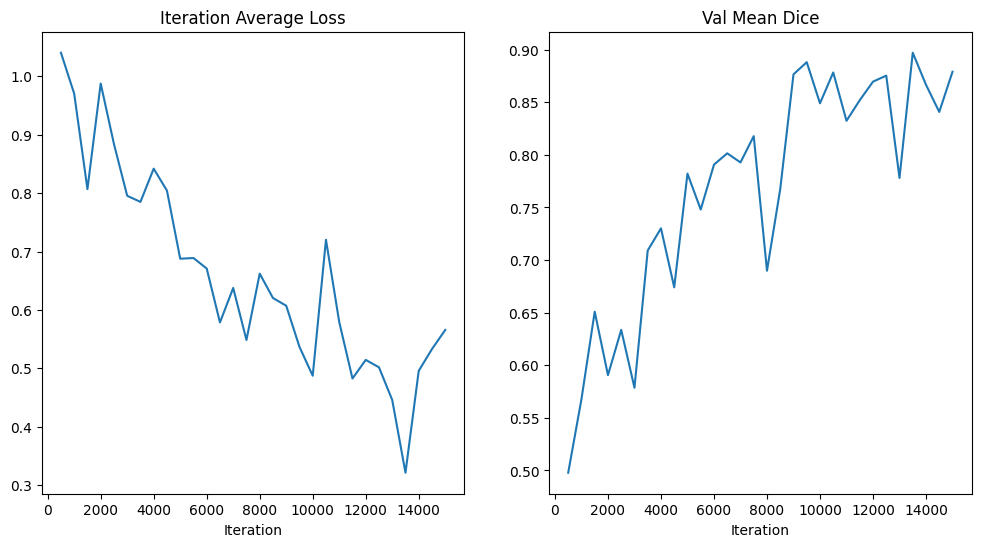

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Inference

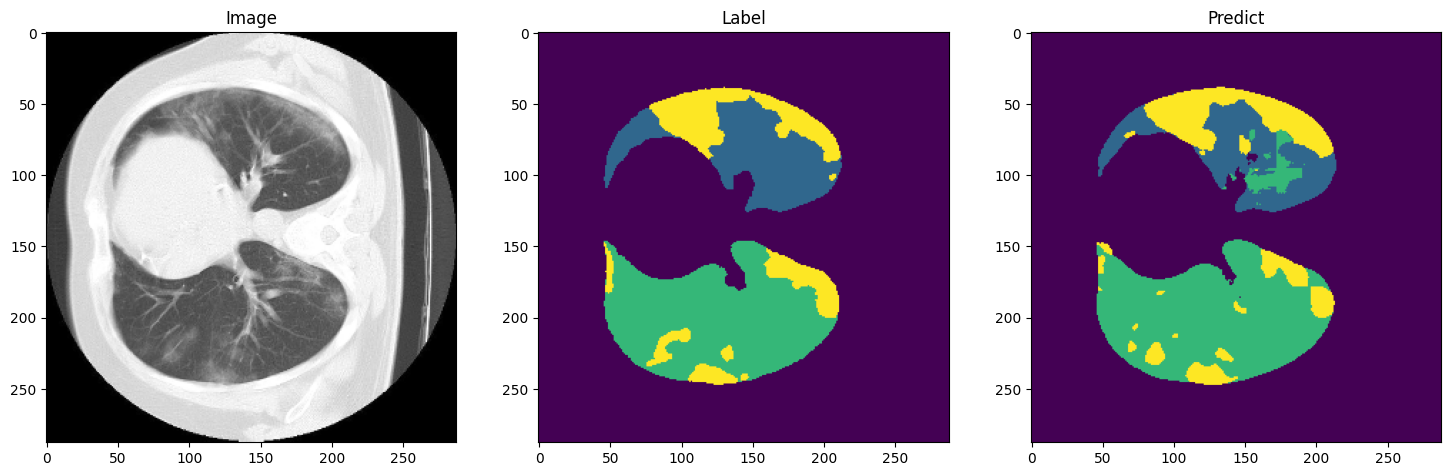

In [ ]:
case_num = 0
slice_num = 50

model.load_state_dict(torch.load(checkpoints_path + "/best_metric_model.pth"))
model.eval()
with torch.no_grad():
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    ax1.set_title('Image')
    ax2.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    ax2.set_title(f'Label')
    ax3.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_num])
    ax3.set_title(f'Predict')
    plt.show()

# Now, let's compare how the model performs without SSL pretrained weights

In [ ]:
model = SwinUNETR(
    in_channels=1,
    out_channels=4,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [ ]:
checkpoints_path_no_ssl = "/content/drive/MyDrive/SIBGRAPI/SwinUNETR/checkpoints/no_ssl/"
os.makedirs(checkpoints_path_no_ssl, exist_ok=True)

In [ ]:
import gc
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

max_iterations = 15000
eval_num = 500
post_label = AsDiscrete(to_onehot=4) # class n
post_pred = AsDiscrete(argmax=True, to_onehot=4) # class n
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    gc.collect()
    torch.cuda.empty_cache()
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(checkpoints_path_no_ssl + "best_metric_model.pth"))

Training (500 / 15000 Steps) (loss=1.04246):  83%|████████▎ | 15/18 [00:41<00:30, 10.30s/it]


Model Was Saved ! Current Best Avg. Dice: 0.48812004923820496 Current Avg. Dice: 0.48812004923820496


Training (1000 / 15000 Steps) (loss=0.98374):  61%|██████    | 11/18 [00:18<00:29,  4.18s/it]


Model Was Saved ! Current Best Avg. Dice: 0.5039821267127991 Current Avg. Dice: 0.5039821267127991


Training (1500 / 15000 Steps) (loss=0.90514):  39%|███▉      | 7/18 [00:16<00:49,  4.53s/it]


Model Was Saved ! Current Best Avg. Dice: 0.6628957986831665 Current Avg. Dice: 0.6628957986831665


Training (2000 / 15000 Steps) (loss=0.73255):  17%|█▋        | 3/18 [00:12<01:25,  5.68s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.6628957986831665 Current Avg. Dice: 0.5681991577148438


Training (2500 / 15000 Steps) (loss=1.04708):  94%|█████████▍| 17/18 [00:21<00:03,  3.92s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.6628957986831665 Current Avg. Dice: 0.5758373141288757


Training (3000 / 15000 Steps) (loss=0.99103):  72%|███████▏  | 13/18 [00:19<00:19,  3.96s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.6628957986831665 Current Avg. Dice: 0.6299152374267578


Training (3500 / 15000 Steps) (loss=0.56588):  50%|█████     | 9/18 [00:17<00:38,  4.27s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7021657228469849 Current Avg. Dice: 0.7021657228469849


Training (4000 / 15000 Steps) (loss=0.72923):  28%|██▊       | 5/18 [00:14<00:59,  4.61s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7021657228469849 Current Avg. Dice: 0.585923433303833


Training (4500 / 15000 Steps) (loss=0.79376):   6%|▌         | 1/18 [00:11<03:17, 11.61s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7021657228469849 Current Avg. Dice: 0.6700680255889893


Training (5000 / 15000 Steps) (loss=0.64239):  83%|████████▎ | 15/18 [00:20<00:11,  3.92s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7021657228469849 Current Avg. Dice: 0.6516757011413574


Training (5500 / 15000 Steps) (loss=0.61857):  61%|██████    | 11/18 [00:18<00:27,  3.99s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7021657228469849 Current Avg. Dice: 0.6979051232337952


Training (6000 / 15000 Steps) (loss=0.49066):  39%|███▉      | 7/18 [00:16<00:50,  4.56s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7394778728485107 Current Avg. Dice: 0.7394778728485107


Training (6500 / 15000 Steps) (loss=0.62182):  17%|█▋        | 3/18 [00:13<01:29,  5.98s/it]


Model Was Saved ! Current Best Avg. Dice: 0.7425228357315063 Current Avg. Dice: 0.7425228357315063


Training (7000 / 15000 Steps) (loss=0.74238):  94%|█████████▍| 17/18 [00:21<00:03,  3.90s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7425228357315063 Current Avg. Dice: 0.6930315494537354


Training (7500 / 15000 Steps) (loss=0.56452):  72%|███████▏  | 13/18 [00:19<00:19,  3.95s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.7425228357315063 Current Avg. Dice: 0.7341875433921814


Training (8000 / 15000 Steps) (loss=0.66506):  50%|█████     | 9/18 [00:23<00:55,  6.21s/it]


Model Was Saved ! Current Best Avg. Dice: 0.817829430103302 Current Avg. Dice: 0.817829430103302


Training (8500 / 15000 Steps) (loss=0.54861):  28%|██▊       | 5/18 [00:14<00:59,  4.59s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.817829430103302 Current Avg. Dice: 0.7970091104507446


Training (9000 / 15000 Steps) (loss=0.41685):   6%|▌         | 1/18 [00:11<03:18, 11.66s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.817829430103302 Current Avg. Dice: 0.808565616607666


Training (9500 / 15000 Steps) (loss=0.57143):  83%|████████▎ | 15/18 [00:26<00:17,  5.70s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8258447647094727 Current Avg. Dice: 0.8258447647094727


Training (10000 / 15000 Steps) (loss=0.72044):  61%|██████    | 11/18 [00:18<00:28,  4.01s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8258447647094727 Current Avg. Dice: 0.7604026198387146


Training (10500 / 15000 Steps) (loss=0.74175):  39%|███▉      | 7/18 [00:15<00:46,  4.22s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8258447647094727 Current Avg. Dice: 0.7361611127853394


Training (11000 / 15000 Steps) (loss=0.37947):  17%|█▋        | 3/18 [00:13<01:31,  6.07s/it]


Model Was Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.8681783676147461


Training (11500 / 15000 Steps) (loss=0.47060):  94%|█████████▍| 17/18 [00:21<00:03,  3.91s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.7105079889297485


Training (12000 / 15000 Steps) (loss=0.69956):  72%|███████▏  | 13/18 [00:19<00:19,  3.96s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.7666662931442261


Training (12500 / 15000 Steps) (loss=0.35072):  50%|█████     | 9/18 [00:16<00:36,  4.05s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.8422585129737854


Training (13000 / 15000 Steps) (loss=0.70570):  28%|██▊       | 5/18 [00:14<00:59,  4.60s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.8349940776824951


Training (13500 / 15000 Steps) (loss=0.38370):   6%|▌         | 1/18 [00:11<03:18, 11.69s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.8537502884864807


Training (14000 / 15000 Steps) (loss=0.47985):  83%|████████▎ | 15/18 [00:20<00:11,  3.91s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.8671542406082153


Training (14500 / 15000 Steps) (loss=0.58565):  61%|██████    | 11/18 [00:17<00:27,  3.97s/it]


Model Was Not Saved ! Current Best Avg. Dice: 0.8681783676147461 Current Avg. Dice: 0.8199781179428101


Training (15000 / 15000 Steps) (loss=0.68328):  39%|███▉      | 7/18 [00:21<01:07,  6.18s/it]


Model Was Saved ! Current Best Avg. Dice: 0.883357048034668 Current Avg. Dice: 0.883357048034668


Training (15011 / 15000 Steps) (loss=0.39389): 100%|██████████| 18/18 [00:28<00:00,  1.58s/it]


<All keys matched successfully>

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} at iteration: {global_step_best}")

train completed, best_metric: 0.8834 at iteration: 15000


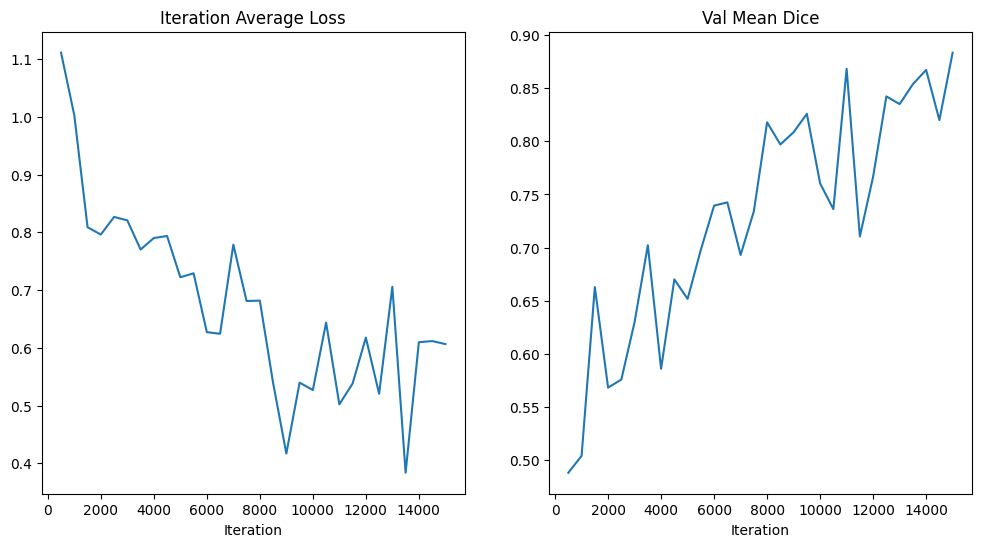

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

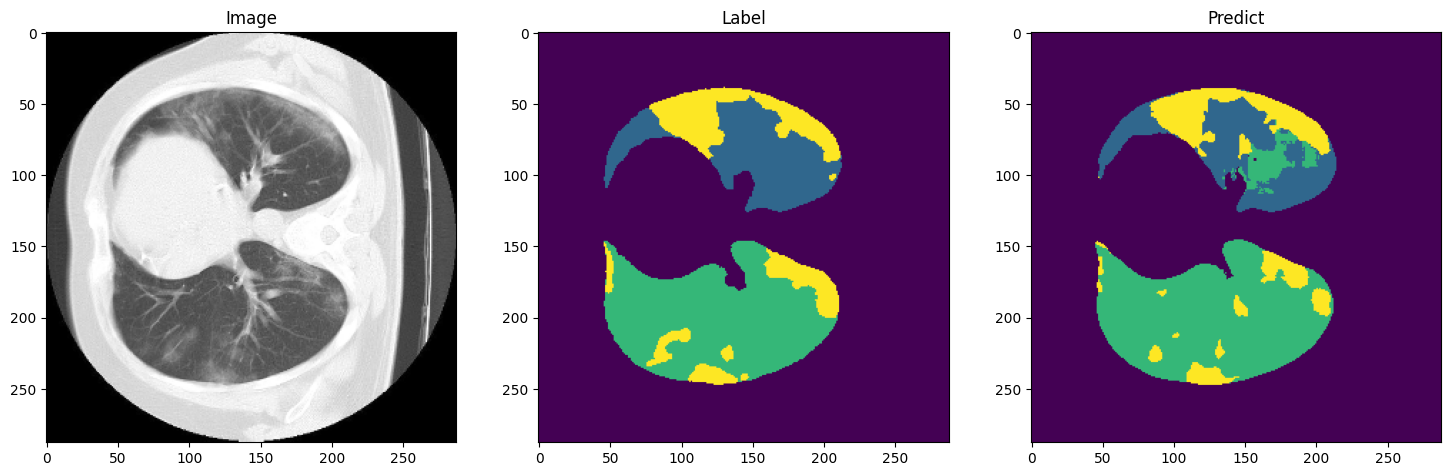

In [ ]:
case_num = 0
slice_num = 50

model.load_state_dict(torch.load(checkpoints_path_no_ssl + "/best_metric_model.pth"))
model.eval()
with torch.no_grad():
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (96, 96, 96), 4, model, overlap=0.8
    )
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    ax1.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    ax1.set_title('Image')
    ax2.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    ax2.set_title(f'Label')
    ax3.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_num])
    ax3.set_title(f'Predict')
    plt.show()

## As we can see, the model trained without SSL pretrained weights initialization got a slightly worse Average Dice Score on the validation set.


## Result with SSL weights pretraining => Average Dice Score =  89,70%
## Result without pretraining => Average Dice Score = 88,34%